<a href="https://colab.research.google.com/github/sama25051997/FER-2013/blob/main/FER_2013.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

number of instances:  1123
instance length:  2304
1121 train samples
0 test samples


Weights have been loaded
Enter Full Path: lol2.jpg


/usr/local/lib/python3.8/dist-packages/keras/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


1/1 [==============================] - 0s 402ms/step


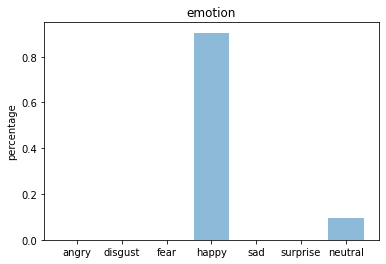

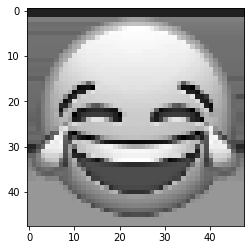

In [1]:
import cv2
import sys
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten

#from keras.preprocessing import image
import keras.utils as image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt

#------------------------------
#cpu - gpu configuration
config = tf.compat.v1.ConfigProto(device_count = {'GPU': 1 , 'CPU': 56}) #max: 1 gpu, 56 cpu
sess = tf.compat.v1.Session(config=config) 
keras.backend.set_session(sess)
#------------------------------
#variables
num_classes = 7 #angry, disgust, fear, happy, sad, surprise, neutral
batch_size = 256
epochs = 5

with open("fer2013.csv") as f:
    content = f.readlines()

lines = np.array(content)
num_of_instances = lines.size
print("number of instances: ",num_of_instances)
print("instance length: ",len(lines[1].split(",")[1].split(" ")))

#------------------------------
#initialize trainset and test set
x_train, y_train, x_test, y_test = [], [], [], []

#------------------------------
#transfer train and test set data
for i in range(1,num_of_instances):
    try:
        emotion, img, usage = lines[i].split(",")
        val = img.split(" ")
        pixels = np.array(val, 'float32')
        emotion = keras.utils.to_categorical(emotion, num_classes)
        if 'Training' in usage:
            y_train.append(emotion)
            x_train.append(pixels)
        elif 'PublicTest' in usage:
            y_test.append(emotion)
            x_test.append(pixels)
    except:
        print("",end="")

#------------------------------
#data transformation for train and test sets
x_train = np.array(x_train, 'float32')
y_train = np.array(y_train, 'float32')
x_test = np.array(x_test, 'float32')
y_test = np.array(y_test, 'float32')

x_train /= 255 #normalize inputs between [0, 1]
x_test /= 255

x_train = x_train.reshape(x_train.shape[0], 48, 48, 1)
x_train = x_train.astype('float32')
x_test = x_test.reshape(x_test.shape[0], 48, 48, 1)
x_test = x_test.astype('float32')

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
#------------------------------
#construct CNN structure
model = Sequential()

#1st convolution layer
model.add(Conv2D(128, (5, 5), activation='relu', input_shape=(48,48,1)))
model.add(MaxPooling2D(pool_size=(5,5), strides=(2, 2)))

#2nd convolution layer
#model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(AveragePooling2D(pool_size=(3,3), strides=(2, 2)))

#3rd convolution layer
#model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(AveragePooling2D(pool_size=(3,3), strides=(2, 2)))

model.add(Flatten())

#fully connected neural networks
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(num_classes, activation='softmax'))
#------------------------------
#batch process
gen = ImageDataGenerator()
train_generator = gen.flow(x_train, y_train, batch_size=batch_size)

#------------------------------
checkpoint = ModelCheckpoint("weights.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

model.compile(loss='categorical_crossentropy'
  , optimizer=keras.optimizers.Adam()
  , metrics=['accuracy']
)

#------------------------------
"""""
fit = True

if fit == True:
	#model.fit_generator(x_train, y_train, epochs=epochs) #train for all trainset
	model.fit_generator(train_generator, steps_per_epoch=batch_size, epochs=epochs) #train for randomly selected one

model.save_weights('weights.h5') #load weights
"""
model.load_weights('weights.h5') #load weights
print('Weights have been loaded')

	
#------------------------------
"""
#overall evaluation
score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', 100*score[1])
"""
#------------------------------
#function for drawing bar chart for emotion preditions
def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')

    plt.show()
#------------------------------

monitor_testset_results = False

if monitor_testset_results == True:
	#make predictions for test set
	predictions = model.predict(x_test)

	index = 0
	for i in predictions:
		if index < 30 and index >= 20:
			#print(i) #predicted scores
			#print(y_test[index]) #actual scores
			
			testing_img = np.array(x_test[index], 'float32')
			testing_img = testing_img.reshape([48, 48]);
			
			plt.gray()
			plt.imshow(testing_img)
			plt.show()
			 
			print(i)
			
			emotion_analysis(i)
			print("----------------------------------------------")
		index = index + 1

#------------------------------
#make prediction for custom image out of test set
img_name = input("Enter Full Path: ")
img = image.load_img(img_name, grayscale=True, target_size=(48, 48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(x)
plt.show()
